# Perdas do Conversor Dois Níveis
## Perdas de comutação e Perdas de Condução

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def detectCommutation(y):
    """
    The function returns 1 where the signal has a positive commutation and
    -1 where the signal has a negative commutation.

    :param y: (numpy.array) The signal to the commutation analysis.
    :return: numpy.array
    """
    y1 = y[:-1]
    y2 = y[1:]

    diff = y2 - y1

    return y1, y2, diff


def rmsValue(signal):
    """
    Calculate the RMS value.
    :param signal: (numpy.array) The signal to do the RMS calculation.
    :return: float
    """

    return np.sqrt(np.sum(np.power(signal, 2)) / signal.size)


def conductionLoss_function(Vx0, Rx0, current):
    """
    x is CE (Collector-Emitter) for IGBTs and F (Forward) for diodes
    """

    return Vx0 * np.mean(current) + Rx0 * np.power(rmsValue(current), 2)


In [3]:
def tableConductionLosses(switch_s1, current, VCE0_IGBT=1.4,
                          VF0_Diode=1.1, RCE_IGBT=6.3e-3, RF0_Diode=3e-3):
    """
    Calculate the conduction loses to a 2-level inverter, a simple leg with 2 IGBTs (2 switchs and 2 Diodes).

    Default values used is available in:
    https://www.semikron.com/dl/service-support/downloads/download/semikron-datasheet-skm400gb125d-22890626/

    :param switch_s1: (list or array-like) The command of the top switch.
    From this command the function calculate the the bottom one too
    :param current: (list or array-like) The current that crosses the converter.

    :param VCE0_IGBT: (float) Is the threshold voltage of the IGBT switch, present in the datasheet of the converter.
    (VCE0, 25°C)
    :param VF0_Diode: (float) Is the threshold voltage of the Diode, present in the datasheet of the converter.
    (rCE0, 25°C)
    :param RCE_IGBT: (float) Is the series resistance of the IGBT switch, present in the datasheet of the converter.
    (VF0, 25°C)
    :param RF0_Diode: (float) Is the series resistance of the Diode, present in the datasheet of the converter.
    (rF, 25°C)
    :return: dict
    """

    # Bring the signal to the numpy.array type
    switch_s1 = np.array(switch_s1)
    current = np.array(current)

    # Creating from switch_s1 the signal of switch S2 (switch_s2)
    switch_s2 = switch_s1 == 0

    # Checking each component current
    s1_times_current = switch_s1 * current
    s2_times_current = switch_s2 * current

    # Taking the index where the current is positive and negative
    pos_current = current >= 0
    neg_current = current < 0

    # Providing the current for each two-level inverter component
    # (2 switchs, 2 diodes)
    current_s1 = np.zeros(current.size)
    current_s1[pos_current] = s1_times_current[pos_current]

    current_d1 = np.zeros(current.size)
    current_d1[neg_current] = -1 * s1_times_current[neg_current]

    current_s2 = np.zeros(current.size)
    current_s2[neg_current] = -1 * s2_times_current[neg_current]

    current_d2 = np.zeros(current.size)
    current_d2[pos_current] = s2_times_current[pos_current]

    s1_cd = conductionLoss_function(VCE0_IGBT, RCE_IGBT, current_s1)
    s2_cd = conductionLoss_function(VCE0_IGBT, RCE_IGBT, current_s2)
    d1_cd = conductionLoss_function(VF0_Diode, RF0_Diode, current_d1)
    d2_cd = conductionLoss_function(VF0_Diode, RF0_Diode, current_d2)

    P_cd = {'S1': s1_cd, 'S2': s2_cd,
            'D1': d1_cd, 'D2': d2_cd}

    return P_cd


def tableSwitchingLosses(
    switch_s1, current, duration, Vdc_converter,
    eon_params=[1.23e-10, 1.39e-08, 6.96e-05, 4.64e-03],
    eoff_params=[1.72e-10, -1.57e-07, 1.05e-04, -1.04e-03],
    erec_params=[7.25e-11, -1.32e-07, 8.53e-05, 1.81e-03],
    Vcc_datasheet=600):
    """
    Calculate the switching loses to a 2-level inverter, a simple leg with 2 IGBTs (2 switchs and 2 Diodes).

    Default values used is available (to measure) in:
    https://www.semikron.com/dl/service-support/downloads/download/semikron-datasheet-skm400gb125d-22890626/

    :param switch_s1: (list or array-like) The command of the top switch.
    :param current: (list or array-like) The current that crosses the converter.
    :param duration: (float) The total duration of the signals ``switch_s1`` and ``current``.
    For power calculation in Watts.
    :param Vcc_converter: (float) The DC bus voltage value of the converter.
    :param eon_params: (list or array-like) Coefficients of the curve Eon losses.
    :param eoff_params: (list or array-like) Coefficients of the curve Eoff losses.
    :param erec_params: (list or array-like) Coefficients of the curve Erec losses.
    :param Vcc_datasheet: (float) The DC voltage value for the curves reference in datasheet.
    :return: tuple of dicts
    """

    # Bring the signal to the numpy.array type
    switch_s1 = np.array(switch_s1)
    current = np.array(current)

    # Creating the polynomials from the coefficients and put in the real DC Bus voltage
    eon = (Vdc_converter/2) / Vcc_datasheet * np.poly1d(eon_params)
    eoff = (Vdc_converter/2) / Vcc_datasheet * np.poly1d(eoff_params)
    erec = (Vdc_converter/2) / Vcc_datasheet * np.poly1d(erec_params)

    # Detect where happens commutations and what kind of commutation (Opening or closing)
    _, _, commut = detectCommutation(switch_s1)

    commut_pos = commut == 1
    commut_neg = commut == -1

    # The commutation detection take off one element of switch_s1 signal, so we need to rearrange the current signal
    current0 = current[1:]

    # Detect where (in time) the current is positive and negative
    current_pos = current0 >= 0
    current_neg = current0 < 0

    # This is boolean operations isolating the moments where:
    #    -> The commutation is negative and the current positive
    #    -> The commutation is negative and the current negative
    #    -> The commutation is positive and the current positive
    #    -> The commutation is positive and the current negative

    comut_neg_cur_pos = commut_neg * current_pos
    comut_neg_cur_neg = commut_neg * current_neg
    comut_pos_cur_pos = commut_pos * current_pos
    comut_pos_cur_neg = commut_pos * current_neg

    # The current signal is indexed using the signals above and is calculated the absolute value.
    current_comut_neg_cur_pos = np.abs(current0[comut_neg_cur_pos])
    current_comut_neg_cur_neg = np.abs(current0[comut_neg_cur_neg])
    current_comut_pos_cur_pos = np.abs(current0[comut_pos_cur_pos])
    current_comut_pos_cur_neg = np.abs(current0[comut_pos_cur_neg])

    # For 'S1'
    s1_eoff = eoff(current_comut_neg_cur_pos)
    s1_eon = eon(current_comut_pos_cur_pos)

    # For 'S2'
    s2_eoff = eoff(current_comut_pos_cur_neg)
    s2_eon = eon(current_comut_neg_cur_neg)

    # For 'D1'
    d1_rec = erec(current_comut_neg_cur_neg)

    # For 'D2'
    d2_rec = erec(current_comut_pos_cur_pos)

    # Prevent negative values of all polynomials
    s1_eon[s1_eon < 0] = 0
    s1_eoff[s1_eoff < 0] = 0
    s2_eon[s2_eon < 0] = 0
    s2_eoff[s2_eoff < 0] = 0
    d1_rec[d1_rec < 0] = 0
    d2_rec[d2_rec < 0] = 0

    P_on = {
        'S1': 1 / duration * np.sum(s1_eon),
        'S2': 1 / duration * np.sum(s2_eon),
        'D1': 0.0,
        'D2': 0.0}

    P_off = {
        'S1': 1 / duration * np.sum(s1_eoff),
        'S2': 1 / duration * np.sum(s2_eoff),
        'D1': 1 / duration * np.sum(d1_rec),
        'D2': 1 / duration * np.sum(d2_rec)}

    return P_on, P_off

## Testing the Switching Losses
### 1. Testando a detecção de comutação

In [4]:
y = np.random.randint(0, 2, size=10)
y1, y2, diff = detectCommutation(y)

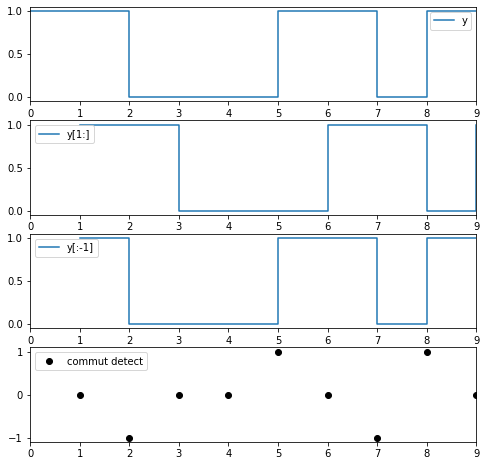

In [5]:
plt.figure(figsize=(8,8))
plt.subplot(411)
plt.step(range(10), y, where='post', label='y')
plt.xlim(0,9)
plt.legend()
plt.subplot(412)
plt.step(range(1, 10), y1, where='post', label='y[1:]')
plt.xlim(0,9)
plt.legend()
plt.subplot(413)
plt.step(range(1,10), y2, where='post', label='y[:-1]')
plt.xlim(0,9)
plt.legend()
plt.subplot(414)
plt.plot(range(1, 10), diff, 'ko ', label='commut detect')
plt.xlim(0,9)
plt.legend()
plt.show()

### 2. Mostrando o sinal simulado para o teste de perdas de comutação

In [6]:
size = 30

np.random.seed(5)
t = np.linspace(0, 2.25/60, size)
sim_switch  = np.random.randint(0, 2, size=size)
sim_current = 1000*np.sin(2*np.pi*60*t)

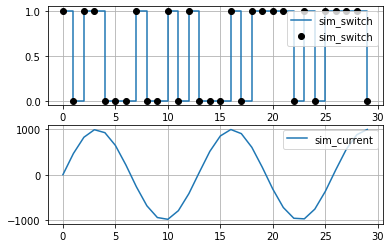

In [7]:
plt.subplot(211)
plt.step(range(sim_switch.size), sim_switch, label='sim_switch', where='post')
plt.plot(range(sim_switch.size), sim_switch, 'ko ', label='sim_switch')
plt.grid(True)
plt.legend()
plt.subplot(212)
plt.plot(sim_current, label='sim_current')
plt.grid(True)
plt.legend()
plt.show()

### 3. Parametrizando as curvas $E_{on}$, $E_{off}$ e $E_{rec}$, retiradas de um manual da ABB para o teste das perdas em comutação com os sinais acima

In [8]:
import numpy as np
# E_on = .4 + 5.63340539e-04*Ic + 5.48091255e-07*Ic**2<br>
# E_off = .05 + 1.86104115e-03*Ic -1.95635972e-07*Ic**2<br>
# E_rec = -3.45e-7 * Ic**2 + 1.45e-3 * Ic + 285e-3

# eon_params = [1,1,1,0]
# eoff_params = [1,1,1,10000000]
# erec_params = [1,1,1,20000000]

# Parâmetros de um manual da ABB
eon_params  = [5.48091255e-07, 5.63340539e-04, .4]
eoff_params = [-1.95635972e-07, 1.86104115e-03, .05]
erec_params = [-3.45e-7, 1.45e-3, 285e-3]

Vo_IGBT = -1
Ro_IGBT = -1

Vo_Diode = -1
Ro_Diode = -1

# Parâmetros de um manual da Semikron
eon_params  = np.array([1.23e-10, 1.39e-8, 6.96e-5, 4.64e-3]) #* 800/600
eoff_params = np.array([1.72e-10, -1.57e-7, 1.05e-4, -1.04e-3]) # * 800/600
erec_params = np.array([7.25e-11, -1.32e-7, 8.53e-5, 1.81e-3]) # * 800/600

Vo_IGBT = 3.85 # [V]
Ro_IGBT = 6.3*1e-3 # [ohm]

Vo_Diode = 2.5 #[V] 
Ro_Diode = 4.3*1e-3 # [ohm]

In [9]:
print('eon_params:', eon_params)
print('eoff_params:', eoff_params)
print('erec_params:', erec_params)

eon_params: [1.23e-10 1.39e-08 6.96e-05 4.64e-03]
eoff_params: [ 1.72e-10 -1.57e-07  1.05e-04 -1.04e-03]
erec_params: [ 7.25e-11 -1.32e-07  8.53e-05  1.81e-03]


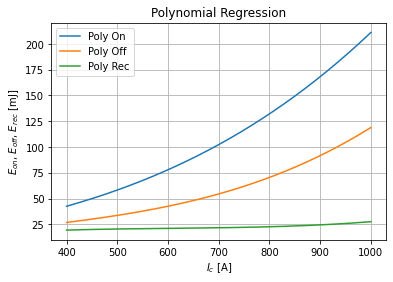

In [10]:
i = np.linspace(400, 1000, 200)

eon = np.poly1d(eon_params)(i)
eoff = np.poly1d(eoff_params)(i)
erec = np.poly1d(erec_params)(i)

import matplotlib.pyplot as plt

plt.plot(i, eon*1e3, label='Poly On')
plt.plot(i, eoff*1e3, label='Poly Off')
plt.plot(i, erec*1e3, label='Poly Rec')
plt.title('Polynomial Regression') 
plt.xlabel('$I_c$ [A]') 
plt.ylabel('$E_{on}$, $E_{off}$, $E_{rec}$ [mJ]')
plt.grid()
plt.legend()
# plt.yticks(np.arange(0, 110, 10))
# plt.xticks(np.arange(100, 650, 50))
# plt.xlim(50, 625)
plt.show()

In [11]:
# P_sw, tmp = tableSwitchingLosses(sim_switch, sim_current, 
#                                  t[-1], t[1] - t[0], 
#                                  eon_params=eon_params, 
#                                  eoff_params=eoff_params, 
#                                  erec_params=erec_params)
# a1, a2, b1, b2, c1, c2, d1, d2 = tmp

Vdc_converter = 800

P_on, P_off = tableSwitchingLosses(sim_switch, sim_current, t[1] - t[0], Vdc_converter, eon_params=eon_params, eoff_params=eoff_params, erec_params=erec_params)

### 7. Resultado Final das potências dissipadas de cada um dos semicondutores $S_1$, $S_2$, $D_1$ e $D_2$ , em Watts

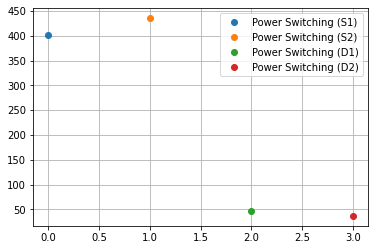

In [12]:
plt.plot([0], P_on['S1']+P_off['S1'], 'o', label='Power Switching (S1)')
plt.plot([1], P_on['S2']+P_off['S2'], 'o', label='Power Switching (S2)')
plt.plot([2], P_on['D1']+P_off['D1'], 'o', label='Power Switching (D1)')
plt.plot([3], P_on['D2']+P_off['D2'], 'o', label='Power Switching (D2)')
plt.grid()
plt.legend()
plt.show()

### Ap. Gráfico com os polinômios gerados para cada equação de energia

In [13]:
i = np.linspace(400, 1000, 200)

In [14]:
# eon = poly_energy(i, eon_params)
# eoff = poly_energy(i, eoff_params)
# erec = poly_energy(i, erec_params)


eon = np.poly1d(eon_params)(i)
eoff = np.poly1d(eoff_params)(i)
erec = np.poly1d(erec_params)(i)

In [15]:
print('eon_params:', eon_params)
print('eoff_params:', eoff_params)
print('erec_params:', erec_params)

eon_params: [1.23e-10 1.39e-08 6.96e-05 4.64e-03]
eoff_params: [ 1.72e-10 -1.57e-07  1.05e-04 -1.04e-03]
erec_params: [ 7.25e-11 -1.32e-07  8.53e-05  1.81e-03]


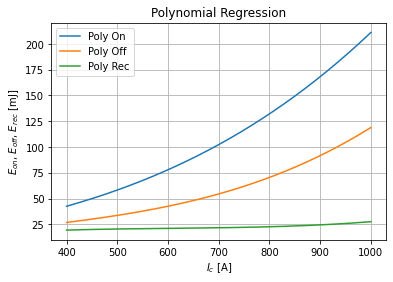

In [16]:
import matplotlib.pyplot as plt

plt.plot(i, eon*1e3, label='Poly On')
plt.plot(i, eoff*1e3, label='Poly Off')
plt.plot(i, erec*1e3, label='Poly Rec')
plt.title('Polynomial Regression') 
plt.xlabel('$I_c$ [A]') 
plt.ylabel('$E_{on}$, $E_{off}$, $E_{rec}$ [mJ]')
plt.grid()
plt.legend()
# plt.yticks(np.arange(0, 110, 10))
# plt.xticks(np.arange(100, 650, 50))
# plt.xlim(50, 625)
plt.show()

## Testing the Conduction Losses

### 1. Generating the signals for test

In [17]:
size = 35

t = np.linspace(0, 1/60, size)

np.random.seed(5)

sim_switch_s1  = np.random.randint(0, 2, size=size)
sim_current = 1000*np.sin(2*np.pi*60*t )
Vdc = 800

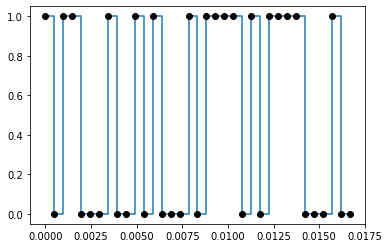

In [18]:
plt.step(t, sim_switch_s1, where='post')
plt.plot(t, sim_switch_s1, 'ko')

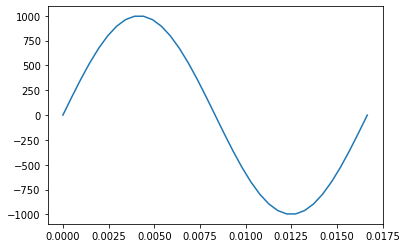

In [19]:
plt.plot(t, sim_current)

In [20]:
P_cd = tableConductionLosses(sim_switch_s1, sim_current, Vo_IGBT, Vo_Diode, Ro_IGBT, Ro_Diode)

### 6. Resultado Final, as perdas em comutação para cada uma dos semicondutores, em Watts

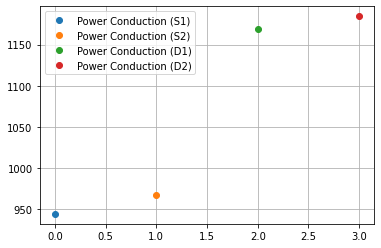

In [21]:
plt.plot([0], P_cd['S1'], 'o', label='Power Conduction (S1)')
plt.plot([1], P_cd['S2'], 'o', label='Power Conduction (S2)')
plt.plot([2], P_cd['D1'], 'o', label='Power Conduction (D1)')
plt.plot([3], P_cd['D2'], 'o', label='Power Conduction (D2)')
plt.grid()
plt.legend()
plt.show()